# Project Submission

Continuous Control for the Udacity Ud893 Deep Reinforcement Learning Nanodegree (DRLND)

## Imports and Dependencies

In [1]:
import sys
sys.path.append("../python")
import random
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
from datetime import datetime
import os

from unityagents import UnityEnvironment

%matplotlib inline

## Unity Environment

Note that if your operating system is Windows (64-bit), the Unity environment is included and you can run the below environment instantiation cell.  

However, if you're using a different operating system, download the file you require from one of the following links:

- Linux: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Linux.zip)
- Mac OSX: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher.app.zip)
- Windows (32-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P2/Reacher/Reacher_Windows_x86.zip)

Then, place the file in the main project directory folder and unzip (or decompress) the file.  Modify the file_name in the below cell and then run the cell.

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Get Default Brain

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Main Training Loop Function

In [4]:
import time

def training_loop(agent, n_episodes=7000, max_t=3000):  
    """DDPG Training Loop
    Params
    ======
        agent (function): agent function
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    
    model_dir = os.getcwd()+"/model_dir"
    os.makedirs(model_dir, exist_ok=True)
    
    start_time = datetime.now()
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations              # get the current state
        agent.reset()
        score = np.zeros(len(env_info.agents))
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations      # get the next state
            reward = env_info.rewards                      # get the reward
            done = env_info.local_done                     # see if episode has finished
            agent.step(state, action, reward, next_state, done, t)
            state = np.copy(next_state)
            score += reward
            if np.any(done):
                break
        scores_window.append(np.amax(score))       # save most recent score
        scores.append(np.amax(score))
        print('\rEpisode {}\tAverage Score: {:.4f}\tScore: {}\tTime: {}'.format(i_episode, np.mean(scores_window), score, datetime.now()-start_time), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}\tScore: {}\tTime: {}'.format(i_episode, np.mean(scores_window), score, datetime.now()-start_time))

            save_dict_list = []
            for i in range(len(env_info.agents)):
                save_dict = {'actor_params': agent.actor_local[i].state_dict(),
                             'actor_optim_params': agent.actor_optimizer[i].state_dict(),
                             'critic_params': agent.critic_local[i].state_dict(),
                             'critic_optim_params': agent.critic_optimizer[i].state_dict()}
                save_dict_list.append(save_dict)
            torch.save(save_dict_list,
                       os.path.join(model_dir, 'episode-{}.pt'.format(i_episode)))                            
            
            
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
            
            save_dict_list = []
            for i in range(len(env_info.agents)):
                save_dict = {'actor_params': agent.actor_local[i].state_dict(),
                             'actor_optim_params': agent.actor_optimizer[i].state_dict(),
                             'critic_params': agent.critic_local[i].state_dict(),
                             'critic_optim_params': agent.critic_optimizer[i].state_dict()}
                save_dict_list.append(save_dict)
                torch.save(save_dict_list,
                           os.path.join(model_dir, 'final-episode.pt'))                
            
            
            break
    return scores

## MADDPG Agent

Agent Parameters:
Number of agents: 2
lr_a: 0.0001
lr_c: 0.001
weight decay: 0
fc1_units: 400
fc2_units: 300
Episode 100	Average Score: 0.0050	Score: [ 0.   -0.01]	Time: 0:02:11.167774
Episode 200	Average Score: 0.0040	Score: [ 0.   -0.01]	Time: 0:04:55.340351
Episode 300	Average Score: 0.0040	Score: [ 0.   -0.01]	Time: 0:07:40.405865
Episode 400	Average Score: 0.0000	Score: [ 0.   -0.01]	Time: 0:10:23.379763
Episode 500	Average Score: 0.0000	Score: [ 0.   -0.01]	Time: 0:13:15.618006
Episode 600	Average Score: 0.0066	Score: [ 0.   -0.01]	Time: 0:16:33.959479
Episode 700	Average Score: 0.0180	Score: [-0.01  0.  ]	Time: 0:20:10.362165
Episode 800	Average Score: 0.0310	Score: [0.3  0.19]	Time: 0:25:04.26602298
Episode 900	Average Score: 0.0219	Score: [ 0.   -0.01]	Time: 0:29:17.293094
Episode 1000	Average Score: 0.0488	Score: [ 0.1  -0.01]	Time: 0:34:26.189568
Episode 1100	Average Score: 0.0952	Score: [ 0.1  -0.01]	Time: 0:42:13.826018
Episode 1200	Average Score: 0.0955	Score: [0.2  0.19]

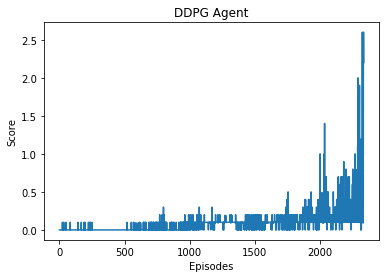

In [5]:
from maddpg_agent import Agent

agent = Agent(num_agents=2, state_size=24, action_size=2, random_seed=2, lr_a=1e-4, lr_c=1e-3,weight_decay=0, fc1_units=400, fc2_units=300)

start = datetime.now()
scores = training_loop(agent)
end = datetime.now()
time_taken = end - start
print('Time: ',time_taken) 

# plot the scores
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.title('MADDPG Agent')
plt.show()

# purposely left commented.  Leave as is.
# env.close()

## Run Smart Agent

In [5]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

from model import Actor

import torch
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, random_seed, fc1_units=400, fc2_units=300):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        self.actor_local = Actor(
            state_size, action_size, random_seed, fc1_units=fc1_units, fc2_units=fc2_units).to(device)

    def act(self, state):
        """Returns actions for given state as per current policy."""

        action = np.zeros(self.action_size)
        state.resize(1, self.state_size)  # reshape for batch processing
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        return np.clip(action, -1, 1)
    
env_info = env.reset(train_mode=False)[brain_name]
num_agents = len(env_info.agents)

# create 2 agents
agent = [Agent(state_size=24, action_size=2, random_seed=2, fc1_units=400, fc2_units=300) for _ in range(num_agents)]

# load each agent
agent_file = torch.load('model_dir/final-episode.pt', map_location='cpu')
for i in range(num_agents):
    agent[i].actor_local.load_state_dict(agent_file[i]['actor_params'])
    
episodes = 1

for i in range(episodes):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations            # get the current state
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    for j in range(400):
        actions = np.zeros([2, 2])
        for i in range(num_agents):
            actions[i] = agent[i].act(state[i])
        env_info = env.step(actions)[brain_name]        # send the action to the environment
        state = env_info.vector_observations   # get the next state
        reward = env_info.rewards                   # get the reward
        done = env_info.local_done                # see if episode has finished                    
        if np.any(done):
            break
        scores += reward
        print('\rEpisode: {}\tStep: {}\tScore: {}'.format(i+1, j+1, scores), end="")
    print('\rEpisode: {}\tStep: {}\tScore: {}'.format(i+1, j+1, scores))
        
# purposely left commented.  Leave as is.
# env.close()

Episode: 2	Step: 400	Score: [1.00000001 1.00000001]
